In [ ]:
#Importing the librairies

import numpy as np
import matplotlib.pyplot as plt
import random
try:
    import importlib
    importlib.reload(h)
    importlib.reload(f)
    importlib.reload(d)
except NameError: # It hasn't been imported yet
    import helpers as h
    import implementations as f
    import data_processing as d

In [128]:
#We fix the random seed in order to get the same results ecery time we run the notebook
np.random.seed(1)

# Data preprocessing and feature selections

## Data preprocessing

To open the data, the data folder needs to be one level above the project folder and the data-dontaining folder needs to be named 'data'. The data folder should contain the following files:
- 'x_train.csv'
- 'y_train.csv'
- 'x_test.csv'

In [ ]:
x_train, x_test, y_train, train_ids, test_ids = h.load_csv_data("../data")

In [ ]:
#Saving the generated arrays in .npy files in order to have faster access to them

np.save('../data/y_train.npy', y_train)
np.save('../data/x_train.npy', x_train)
np.save('../data/x_test.npy', x_test)
np.save('../data/train_ids.npy', train_ids)
np.save('../data/test_ids.npy', test_ids)

In [129]:
#Loading the arrays from the .npy files

x_train = np.load("../data/x_train.npy")
x_test = np.load("../data/x_test.npy")
y_train = np.load("../data/y_train.npy")
train_ids = np.load("../data/train_ids.npy")
test_ids = np.load("../data/test_ids.npy")

In [130]:
#Generates the features names

features_name = np.genfromtxt('../data/x_train.csv', delimiter=',', dtype=str, max_rows=1)[1:] 

## Features selection

The original data contains 321 features, but the majority of them are not useful for the prediction. Therefore, we need to select the features that are useful for the prediction. The American Heart Association (AHA) identifies a range of risk factors for heart disease, including:
- Tobacco and alcohol use
- Physical inactivity
- Nutrution
- Obesity & overweight
- Blood cholesterol
- Diabetes
- Blood pressure

and some factors having an influence on the risk factors as : 
- Age
- Income 
- Education
- Gender
- Access and affordability of health care

To represent these factors, the following 21 features were selected:

- GENHLTH: General health condition
- MENTHLTH: Number of days with mental health not good
- PHYSHLTH: Number of days with physical health not good
- HLTHPLN1 : Health care coverage
- MEDCOST : Delayed medical treatment due to costs
- TOLDHI2 : High blood cholesterol
- CVDSTRK3 : Ever told you had a stroke
- DIABETE3 : Ever told you had diabetes
- SEX : Gender of the respondent
- EDUCA : Level of education
- INCOME2 : Annual household income
- DIFFWALK : Difficulty walking
- SMOKE100 : Smoked at least 100 cigarettes in life
- _RFHYPE5 : High blood pressure
- _CHOLCHK : Checked cholesterol within the last 5 years
- _AGEG5YR : Age group
- _BMI5 : Body mass index
- _TOTINDA : Physical activity
- _FRTLT1 : Fruit consumption
- _VEGLT1 : Vegetable consumption
- _RFDRHV5 : Heavy drinking



In [131]:
#Select the important features
features_list = ['_RFHYPE5', 'TOLDHI2', '_CHOLCHK', '_BMI5', 'SMOKE100', 'CVDSTRK3', 'DIABETE3', '_TOTINDA', '_FRTLT1', '_VEGLT1', '_RFDRHV5', 
                 'HLTHPLN1', 'MEDCOST', 'GENHLTH', 'MENTHLTH', 'PHYSHLTH', 'DIFFWALK', 'SEX', '_AGEG5YR', 'EDUCA', 'INCOME2', ]


In [132]:
#Create a mask for feature selection and apply it to the data

trainMask, testMask = f.masking((x_train, x_test), features_name, features_list)


## Processing
### We clean data for each chosen features, making them binary or trimming the values with no answer

In [133]:
#Train and test feature cleaning and processing

trainProcessed = d.feature_processing_test(trainMask)
testProcessed  = d.feature_processing_test(testMask)

#Replace missing values by the mean of the feature

x_train_algo = f.replaceMissingValuesMean(trainProcessed)
x_test_algo = f.replaceMissingValuesMean(testProcessed)

In [134]:
#Add a column of ones to the data to take into account the bias

tX_train = np.c_[np.ones((len(x_train_algo), 1)), x_train_algo]
tX_test = np.c_[np.ones((len(x_test_algo), 1)), x_test_algo]

### Separation of the dataset in a validation and a training set

In [135]:
split=int((len(tX_train))*0.7)
tX_train_train, tX_train_validation = np.split(tX_train,[split])
y_train_train, y_train_validation = np.split(y_train,[split])


## Balancing the data

One of the main problem of the dataset is that the proportion of persons with heart diseases and persons without heart diseases is not balanced. Indeed, only around 9% have a heart disease. Therefore, to avoid the model to be biased, we need to balance the data. We will try several split of the data to see which one gives the best results. (Computation done on the full length of the dataset before splitting)

| Split                | Sample size with heart diseases | Sample size without heart diseases | Total sample size                  |
|----------------------|---------------------------------|------------------------------------| ---------------------------------- |
| Initial split: 10-90 | 28975                           | 299160                             | 328135                             |
| 50-50                | 28975                           | 28975                              | 57950                              |
| 30-70                | 28975                           | 67608                              | 96583                              |

In [136]:
#Separate de data into the two classes

tX_train_neg = tX_train_train[y_train_train == -1]
tX_train_pos = tX_train_train[y_train_train == 1]

y_train_neg = y_train_train[y_train_train == -1]
y_train_pos = y_train_train[y_train_train == 1]


#Generate a sample of the same size as the heart disease class (or of the size of the wanted split)

random_indices_neg = np.random.choice(len(tX_train_neg), 2*len(tX_train_pos), replace=False)

tX_train_neg_red = tX_train_neg[random_indices_neg,:]
y_train_neg_red = y_train_neg[random_indices_neg]

#Concatenate the two classes

tX_train_train_reduced = np.concatenate((tX_train_neg_red, tX_train_pos))
y_train_train_reduced = np.concatenate((y_train_neg_red, y_train_pos))



## Model Training :

Now that we have our data, we can train our model. We will use the following models:

- Gradient descent with mean squared error
- Stochoastic gradient descent with mean squared error
- Least squares regression
- Ridge regression
- Logistic regression
- Regularized logistic regression

### Initialisation of set parameters

In [137]:
#Random initialization of the weights

initial_w = [random.choice([1, -1]) for i in range(len(tX_train[0]))]

### Algorithms
You can find all the implementations in the annex .py file

1. MSE gradient descent

First of all, we try the algorithm wih several values for gamma to see which one is the optimal one, with the smallest loss. 

Gradient Descent(499/500): Final loss=1.01917553381049
1.0e-03: 1.0192
Gradient Descent(499/500): Final loss=0.6545059519333759
2.0e-03: 0.6545
Gradient Descent(499/500): Final loss=0.5077163098669141
3.0e-03: 0.5077
Gradient Descent(499/500): Final loss=0.44433043340602946
4.0e-03: 0.4443
Gradient Descent(499/500): Final loss=0.41383547086367484
5.0e-03: 0.4138
Gradient Descent(499/500): Final loss=0.39688541901819335
6.0e-03: 0.3969
Gradient Descent(499/500): Final loss=0.38592820050209187
7.0e-03: 0.3859
Gradient Descent(499/500): Final loss=0.3779320530087104
8.0e-03: 0.3779
Gradient Descent(499/500): Final loss=6.925853464093167e+20
9.0e-03: 692585346409316745216.0000


C:\Users\broth\AppData\Local\Temp\ipykernel_9196\1328801782.py:15: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([0, 100])


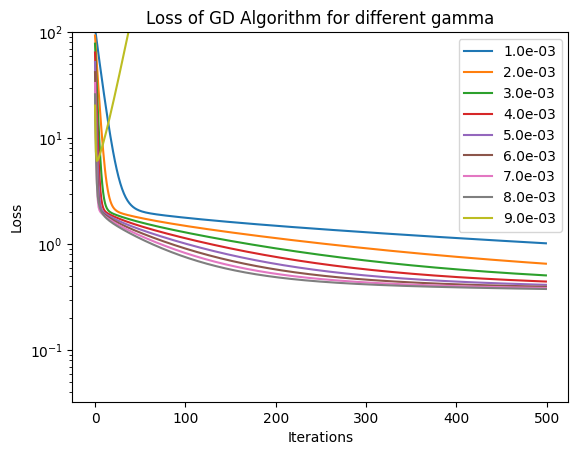

In [72]:
gamma = np.arange(0.001, 0.010, 0.001)
g_opti = gamma[0]
loss_opti = 1000

ax = plt.axes()

#Loop on the different values of gamma
for g in gamma:
    weights, loss = f.mean_squared_error_gd(y_train_train_reduced, tX_train_train_reduced, initial_w, 500, g)
    mean_loss = np.mean(loss[-100:])
    if mean_loss < loss_opti:
        loss_opti = mean_loss
        g_opti = g
    print("%.1e: %.4f" % (g, loss[-1]))
    ax.semilogy(loss, label = "%.1e" % g)


print("Optimal gamma: %.1e" % g_opti)
ax.set_ylim([0, 100])
plt.title("Loss of GD Algorithm for different gamma")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.legend()
plt.show()

No matter the number of iterations, the value of the learning rate matters quite a lot.

The weights are saved at each iterations, and applied on the validation set, in order to see the rate of improvement on the validation set with respect to the training one. 

In [36]:
#Compute gradient descent with MSE as loss function (see functions.py for the function)
w_mse_gd_gamma1, loss_mse_gd_gamma1 = f.mean_squared_error_gd(y_train_train_reduced, tX_train_train_reduced, initial_w, 2000, 0.0078)
w_mse_gd_gamma2, loss_mse_gd_gamma2 = f.mean_squared_error_gd(y_train_train_reduced, tX_train_train_reduced, initial_w, 2000, 0.007)
w_mse_gd_gamma3, loss_mse_gd_gamma3 = f.mean_squared_error_gd(y_train_train_reduced, tX_train_train_reduced, initial_w, 15000, 0.00001)


Gradient Descent(1999/2000): Final loss=0.3325075721779258
Gradient Descent(1999/2000): Final loss=0.33406388395173275
Gradient Descent(14999/15000): Final loss=1.6207174929105999


In [37]:
#Compute the loss on the validation set for the different gamma values

loss_test_set_1 = []
for w in w_mse_gd_gamma1:
    loss_test_set_1.append(f.compute_mse(y_train_validation, tX_train_validation, w))

final_loss_test_1 = loss_test_set_1[-1]

loss_test_set_2 = []
for w in w_mse_gd_gamma2:
    loss_test_set_2.append(f.compute_mse(y_train_validation, tX_train_validation, w))
final_loss_test_2 = loss_test_set_2[-1]

loss_test_set_3 = []
for w in w_mse_gd_gamma3:
    loss_test_set_3.append(f.compute_mse(y_train_validation, tX_train_validation, w))
final_loss_test_3 = loss_test_set_3[-1]

print(final_loss_test_1,final_loss_test_2, final_loss_test_3)


0.2552437025409314 0.257015377296468 1.4138963294700075


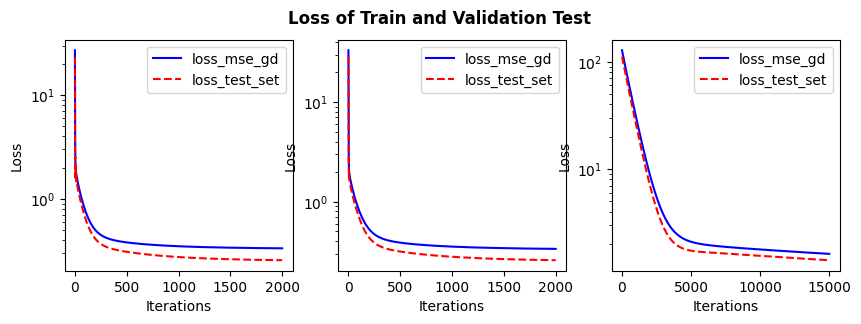

In [38]:
#Plot of the improvement in function of the number of iterations
loss_mse_gd = [loss_mse_gd_gamma1,loss_mse_gd_gamma2,loss_mse_gd_gamma3]
loss_test_set = [loss_test_set_1,loss_test_set_2,loss_test_set_3]

fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# Plotting the loss for training and test set on each subplot
for i in range(3):
    axs[i].semilogy(loss_mse_gd[i], '-b', label='loss_mse_gd')
    axs[i].semilogy(loss_test_set[i], '--r', label='loss_test_set')
    axs[i].legend(frameon=True)
    axs[i].set_xlabel('Iterations')
    axs[i].set_ylabel('Loss')

# Adding a title to the entire figure
fig.suptitle('Loss of Train and Validation Test', fontweight='bold')

plt.show()

Finaly, we compute the algorithm with the optimal value of gamma obtained above, and we check visually whether or not there's an overfitting due to the important number of iterations

In [73]:
 weights_mse_gd, loss_mse_gd = f.mean_squared_error_gd(y_train_train_reduced, tX_train_train_reduced, initial_w, 10000, g_opti)

Gradient Descent(9999/10000): Final loss=0.32628696095416254


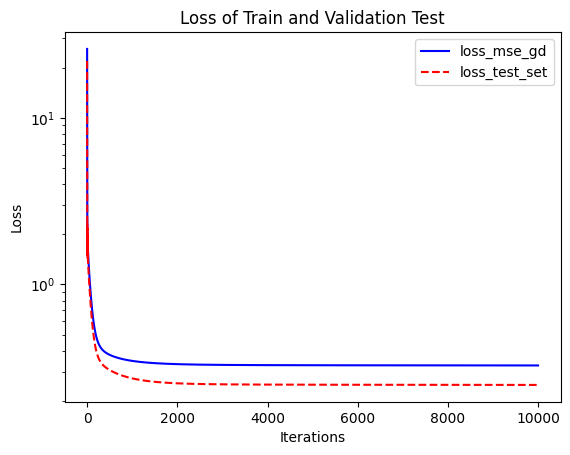

In [111]:
loss_validation_set = []
for w in weights_mse_gd:
    loss_validation_set.append(f.compute_mse(y_train_validation, tX_train_validation, w))

ax = plt.axes()

plt.semilogy(loss_mse_gd, '-b', label='loss_mse_gd')
plt.semilogy(loss_validation_set, '--r', label='loss_test_set')
plt.legend(frameon=True)
plt.title('Loss of Train and Validation Test')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
plt.show()

We compute precision and accuracy metrics on the validation set we created

In [50]:
y_pred = tX_train_validation.dot(w_mse_gd_gamma2[-1, :])
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_validation)/len(y_train_validation))
print("F1 score: ", f1)


Accuracy:  0.8186629554758688
F1 score:  0.3490500674616198


In [ ]:
#h.create_csv_submission(test_ids, y_pred, 'submission_gd_8.csv')

In [78]:
#We apply the model to the test sample

y_test = tX_test.dot(w_mse_gd_gamma2[-1, :])
y_test_rounded = np.where(y_test > 0, 1, -1) 

print('weights = \n\n', w_mse_gd_gamma2[-1, :],'\n\n Loss = ', loss_mse_gd_gamma2[-1],'\n\n*****************************************************************************',
      ' \n\n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_rounded == 1)/len(y_test_rounded))

weights = 

 [-7.73128475e-01  2.02978230e-01  5.40508567e-03  4.06055312e-04
  1.00000000e+00 -1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00 -1.00000000e+00 -8.47176319e-04 -1.32247331e-02
  1.00000000e+00  1.00000000e+00 -3.47449496e-01 -1.90808314e-01
  7.44117942e-02 -9.99238492e-01 -3.76502989e-01 -1.00000000e+00
  1.00000000e+00  1.00000000e+00] 

 Loss =  0.33406388395173275 

*****************************************************************************  

 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.18786970076522916


2. MSE SGD

Similarly to the gradient descent, we try different values of gamma for gradient descent with MSE as loss function 

SGD iter. 999/999: loss=3.59822331653101, w0=-0.9090654119310291, w1=-0.48224926279304375
5.0e-04: 3.5982
SGD iter. 999/999: loss=1.3642032559146353, w0=-0.9139508922200698, w1=-0.3425024207874214
6.7e-04: 1.3642
SGD iter. 999/999: loss=0.5404058028189176, w0=-0.8991350455178935, w1=-0.3113185941587752
8.3e-04: 0.5404
SGD iter. 999/999: loss=0.7483690407344309, w0=-0.8830547796960334, w1=-0.19825611894615067
1.0e-03: 0.7484
SGD iter. 999/999: loss=0.2799150655612962, w0=-0.8973136777546158, w1=-0.11458694030955091
1.2e-03: 0.2799
SGD iter. 999/999: loss=0.06801799847184511, w0=-0.8855513197392866, w1=-0.14470484349049367
1.3e-03: 0.0680
SGD iter. 999/999: loss=0.0033841261920584034, w0=-0.8718009031303321, w1=-0.017389076435518312
1.5e-03: 0.0034
SGD iter. 999/999: loss=0.5360665060265128, w0=-0.9072967356539757, w1=0.05869831828430473
1.7e-03: 0.5361
SGD iter. 999/999: loss=1.4144251330606812, w0=-0.9119559724540655, w1=0.010738588201690092
1.8e-03: 1.4144
SGD iter. 999/999: loss=0.83

C:\Users\broth\AppData\Local\Temp\ipykernel_9196\1001754594.py:20: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([0, 50])


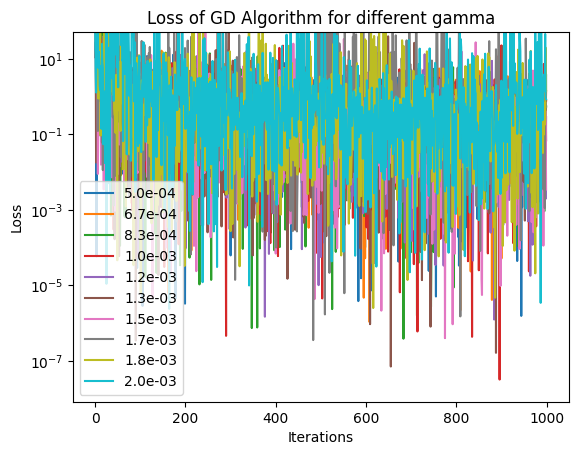

In [98]:
gamma = np.linspace(0.0005, 0.0020, 10)
#gamma = [0.0001, 0.001, 0.01, 0.1]

g_opti = gamma[0]
loss_opti = 1000

ax = plt.axes()
for g in gamma:
    weights, loss = f.mean_squared_error_sgd(y_train_train_reduced, tX_train_train_reduced, initial_w, 1000, g)
    mean_loss = np.mean(loss[-100:])
    if mean_loss < loss_opti:
        loss_opti = mean_loss
        g_opti = g
    print("%.1e: %.4f" % (g, loss[-1]))
    ax.semilogy(loss, label = "%.1e" % g)


print("Optimal gamma: %.1e" % g_opti)

ax.set_ylim([0, 50])
plt.title("Loss of GD Algorithm for different gamma")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.legend()
plt.show()


In [109]:
w_mse_sgd, loss_mse_sgd = f.mean_squared_error_sgd(y_train_train_reduced, tX_train_train_reduced, initial_w, 10000, g_opti)

SGD iter. 9999/9999: loss=0.5501028564901825, w0=-0.7942936902078824, w1=0.19722300496233036


In [249]:
loss_mse_gd

array([25.91712067,  7.43648526,  3.76022459, ...,  0.32628717,
        0.32628707,  0.32628696])

In [250]:
loss_logreg

array([8.43746726, 3.19858523, 2.36646216, 1.76212565, 1.38485405,
       1.19824311, 1.29650498, 1.59218681, 1.79486445, 1.57948807,
       1.54714845, 1.54267107, 1.45100924, 1.48730821, 1.40887504,
       1.46804964, 1.39784374, 1.45821595, 1.37995061, 1.4432547 ,
       1.35883684, 1.42970338, 1.34213448, 1.41942106, 1.32777968,
       1.41019877, 1.31395549, 1.40146677, 1.30103154, 1.39356457,
       1.2891905 , 1.38642653, 1.27817622, 1.37984303, 1.26783583,
       1.37373643, 1.25812807, 1.3680706 , 1.24899596, 1.36278892,
       1.24037182, 1.3578381 , 1.23220363, 1.35317881, 1.22444973,
       1.34877753, 1.21707167, 1.34460349, 1.21003484, 1.34062996,
       1.20330913, 1.33683406, 1.19686789, 1.33319579, 1.19068721,
       1.3296976 , 1.18474571, 1.3263242 , 1.17902423, 1.32306224,
       1.17350557, 1.31990007, 1.16817424, 1.31682749, 1.16301626,
       1.3138356 , 1.15801901, 1.3109166 , 1.15317109, 1.30806369,
       1.14846219, 1.30527091, 1.14388294, 1.30253303, 1.13942

Text(0, 0.5, 'Loss')

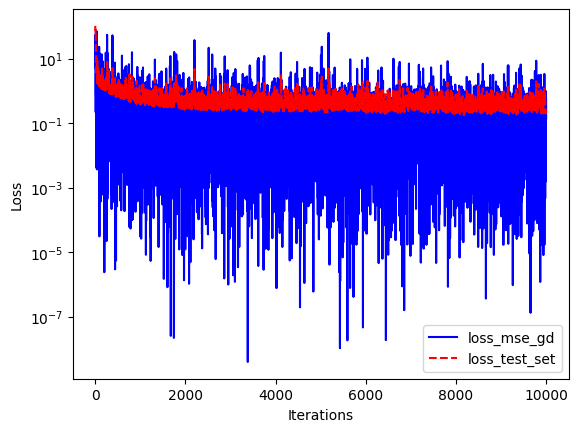

In [110]:
loss_validation_set = []
for w in w_mse_sgd:
    loss_validation_set.append(f.compute_mse(y_train_validation, tX_train_validation, w))

ax = plt.axes()

plt.semilogy(loss_mse_sgd, '-b', label='Loss_mse_sgd')
plt.semilogy(loss_validation_set, '--r', label='loss_validation_set')
plt.legend(frameon=True)
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')

In [113]:
y_pred = tX_train_validation.dot(w_mse_sgd[-1])
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_validation)/len(y_train_validation))

print("F1 score: ", f1)

Accuracy:  0.8134009203482289
F1 score:  0.2960720444529603


In [ ]:
y_test_sgd = tX_test.dot(w_mse_sgd[-1])
y_test_rounded_sgd = np.where(y_test_sgd > 0, 1, -1)

print('weights = \n', w_mse_sgd[-1],'\n Loss = ', loss_mse_sgd[-1],'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_rounded_sgd == 1)/len(y_test_rounded_sgd))

3. Least squares

Least squares method is straight-forward. We apply the algoritm 

For this algorithm, we try different ratios of data in the training dataset to observe whether or not it leads to some improvement. 

In [185]:

splits = np.linspace(1,4,4)
weights = []
losses = []
s_opti = splits[0]
f1_opti = 0
for s in splits: 
    #Similar to the initial split reduction of data seen above
    tX_train_neg_red = tX_train_neg[:int(len(tX_train_pos)*s),:]
    y_train_neg_red = y_train_neg[:int(len(tX_train_pos)*s)]

    tX_train_train_reduced = np.concatenate((tX_train_neg_red, tX_train_pos))
    y_train_train_reduced = np.concatenate((y_train_neg_red, y_train_pos))

    w_ls, loss_ls = f.least_squares(y_train_train_reduced, tX_train_train_reduced)

    weights.append(w_ls)
    losses.append(loss_ls)
    print(f"Split at %.1f/%.1f %%, loss = %.4f" %((s/(s+1)*100), 1/(s+1)*100, loss_ls))
    y_pred = tX_train_validation.dot(w_ls)
    y_pred = np.where(y_pred > 0, 1, -1)

    _,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)
    if f1 > f1_opti:
        f1_opti = f1
        s_opti = s

    print("Accuracy: ", np.sum(y_pred == y_train_validation)/len(y_train_validation))

    print("F1 score: ", f1)


Split at 50.0/50.0 %, loss = 0.3203
0.35810998911750563
Accuracy:  0.7423532877561179
F1 score:  0.35810998911750563
Split at 66.7/33.3 %, loss = 0.3007
0.4068627450980392
Accuracy:  0.8475838319399437
F1 score:  0.4068627450980392
Split at 75.0/25.0 %, loss = 0.2684
Accuracy:  0.8869475117075203
F1 score:  0.38814668206058606
Split at 80.0/20.0 %, loss = 0.2391
Accuracy:  0.9032009020631647
F1 score:  0.3275703902335756


It seems the optimal split is the ratio comprising twice the amount of data with heart disease than without. We will use this ratio for the other methods aswell.

In [187]:
    tX_train_neg_red = tX_train_neg[:int(len(tX_train_pos)*s_opti),:]
    y_train_neg_red = y_train_neg[:int(len(tX_train_pos)*s_opti)]

    tX_train_train_reduced = np.concatenate((tX_train_neg_red, tX_train_pos))
    y_train_train_reduced = np.concatenate((y_train_neg_red, y_train_pos))

In [193]:
w_ls, loss_ls = f.least_squares(y_train_train_reduced, tX_train_train_reduced)

In [194]:
y_pred = tX_train_validation.dot(w_ls)
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_validation)/len(y_train_validation))

print("F1 score: ", f1)

Accuracy:  0.8475838319399437
F1 score:  0.4068627450980392


In [195]:

y_test_ls = tX_test.dot(w_ls)
y_test_ls = np.where(y_test_ls > 0, 1, -1)

print('weights = \n', w_ls,'\n Loss = ', loss_ls,'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_ls == 1)/len(y_test_ls))

weights = 
 [-0.08327563  0.14537865  0.00223654  0.00044005 -0.06180804 -0.03361978
 -0.22164132 -0.42265745 -0.07863368 -0.22883214 -0.00890023 -0.01572196
 -0.16091321 -0.10390355 -0.19235511  0.12462448  0.0546625  -0.33881248
  0.06115368 -0.0064018  -0.00522325 -0.01217399] 
 Loss =  0.30074124873607244 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.16729902449281855


In [ ]:
h.create_csv_submission(test_ids, y_test_ls, 'submission_ls_8.csv')

4. Ridge regression


The ridge regression differs from the least squares as we apply a malus to the complexification of the weights. We try to identify which should be the optimal weight we attribute to this malus.

In [225]:
#Try different values of gamma for gradient descent with MSE as loss function
gamma = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 1]
#gamma = np.linspace(1*10**(-7),1*10**-2 , 8)
g_opti = gamma[0]
loss_opti = 1000
f1_opti = 0
for g in gamma:
    w_ridge, loss_ridge = f.ridge_regression(y_train_train_reduced, tX_train_train_reduced, g)
    print("%.2e: %f" % (g, loss_ridge))


    y_pred = tX_train_validation.dot(w_ridge)
    y_pred = np.where(y_pred > 0, 1, -1)
    _,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)

    if f1 > f1_opti:
        loss_opti = loss_ridge
        g_opti = g
        f1_opti = f1
    print("F1 score: %.6f \n" % f1)

print("optimal gamma: %.e " % g_opti)


1.00e-07: 0.300741
F1 score: 0.406863 

1.00e-06: 0.300741
F1 score: 0.406863 

1.00e-05: 0.300741
F1 score: 0.407005 

1.00e-04: 0.300742
F1 score: 0.407210 

1.00e-03: 0.300770
F1 score: 0.407178 

1.00e-02: 0.301292
F1 score: 0.405410 

1.00e+00: 0.343422
F1 score: 0.329240 

optimal gamma: 1e-04 


The optimal weight to attribute to the malus seems to be 0.0001, as it gives the best F1 score on the validation set. We will the used this value in the training of the model

In [212]:
w_ridge, loss_ridge = f.ridge_regression(y_train_train_reduced, tX_train_train_reduced, g_opti)

The accuracy and the F1-score computed on the validation set are show below. 

In [213]:
y_pred = tX_train_validation.dot(w_ridge)
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_validation)/len(y_train_validation))

print("F1 score: ", f1)

Accuracy:  0.8476549405227497
F1 score:  0.4072097711371991


Test set label attributions

In [214]:
y_test_ridge = tX_test.dot(w_ridge)
y_test_ridge = np.where(y_test_ridge > 0, 1, -1)

print('weights = \n', w_ridge,'\n Loss = ', loss_ridge,'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_ridge == 1)/len(y_test_ridge))

weights = 
 [-0.08769108  0.14523005  0.00224687  0.00043884 -0.0618429  -0.03363197
 -0.22147051 -0.42183348 -0.07853322 -0.22861652 -0.00896958 -0.01575225
 -0.16060205 -0.10393922 -0.19204503  0.12407215  0.05472466 -0.32250502
  0.06034555 -0.00650184 -0.00522239 -0.01233579] 
 Loss =  0.30074180369568726 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.1673355945839695


In [ ]:
#h.create_csv_submission(test_ids, y_test_ridge, 'submission_ridge.csv')

5. Logistic regression

For the logistic regression, the datas are processed once again as the -1 needs to be transformed to 0. 

In [241]:
#Transformation of the label, so taht we can use the logistic regression function
y_train_train_red_lg = np.where(y_train_train_reduced == 1, 1, 0)
y_train_validation_lg = np.where(y_train_validation == 1, 1, 0)
initial_w = [random.choice([1, 0]) for i in range(len(tX_train[0]))]
#transform initial_w as an array
initial_w = np.array(initial_w)

Then, we try different values of gamma on a small number of iteration in order to extract the optimal one 

Gradient Descent(99/99): loss=0.9971101413729678, w0=0.795949015420275, w1=-0.3434377707787332
1.00e-02, loss = 0.997
F1 score: 0.149504 

Gradient Descent(99/99): loss=0.8701251979676727, w0=0.7528657611343146, w1=-0.3115616178606892
2.00e-02, loss = 0.870
F1 score: 0.174036 

Gradient Descent(99/99): loss=0.7858366892818597, w0=0.7179921294120163, w1=-0.2754457895944416
3.00e-02, loss = 0.786
F1 score: 0.188450 

Gradient Descent(99/99): loss=0.7227061082693703, w0=0.6879824244033484, w1=-0.23755232904820525
4.00e-02, loss = 0.723
F1 score: 0.200536 

Gradient Descent(99/99): loss=0.6748938924663684, w0=0.661412921647662, w1=-0.19944117410020717
5.00e-02, loss = 0.675
F1 score: 0.212916 

Gradient Descent(99/99): loss=0.747694899811062, w0=0.6335727774922428, w1=-0.17632513945608624
6.00e-02, loss = 0.748
F1 score: 0.114589 

Gradient Descent(99/99): loss=0.8269030392023142, w0=0.6196395160085818, w1=-0.14804039457595353
7.00e-02, loss = 0.827
F1 score: 0.090017 

Gradient Descent(99

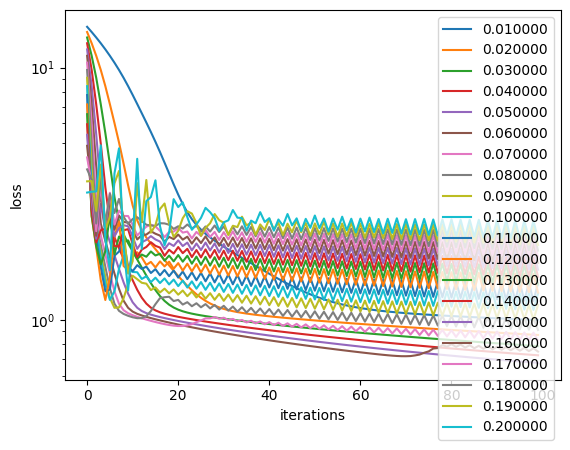

In [232]:
#Try different values of gamma for gradient descent with MSE as loss function
gamma = np.linspace(1*10**(-2), 2*10**(-1), 20)
#gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
g_opti = gamma[0]
loss_opti = 1000
f1_opti = 0
for g in gamma:
    w_logreg, loss_logreg = f.logistic_regression(y_train_train_red_lg, tX_train_train_reduced, initial_w, 100, g)
    print("%.2e, loss = %.3f" % (g, loss_logreg[-1]))
    plt.semilogy(loss_logreg, label = "%f" % g)

    y_pred = tX_train_validation.dot(w_logreg[-1])
    y_pred = np.where(y_pred > 0.5, 1, 0)
    y_pred = np.where(y_pred == 1, 1, -1)

    _,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)

    
    if f1 > f1_opti:
        loss_opti = loss_ridge
        g_opti = g
        f1_opti = f1
    print("F1 score: %.6f \n" % f1)


print("optimal gamma: %e, F1-score =  %.6f, Loss = %.3f " % (g_opti, f1_opti, loss_opti))
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

The best learning rate is 0.1.

In [251]:
w_logreg, loss_logreg = f.logistic_regression(y_train_train_lg, tX_train_train_reduced,initial_w, 500, g_opti)

Gradient Descent(499/499): loss=1.032709904208554, w0=-0.686223677612764, w1=0.6816179419983187


11.472997832289805
4.045631131606743
2.623228463096024
2.2891448688220106
1.8476383965343508
1.4914644728807502
1.2895402776011529
1.1688360145173937
1.0560356819695325
1.0007249354161276
0.8744202056556561
0.9688453160966546
0.6450173141640823
1.5769391670547668
0.5425477637720909
2.018614393949333
0.5156728979836019
1.8454390156126672
0.4601465090003193
1.7958769534809318
0.44700396327387826
1.7776517632547275
0.43700815276585125
1.7578389064334494
0.4280298165217464
1.736858999274826
0.4205118469245478
1.7213310565152637
0.4142719382405883
1.7083701322443794
0.408802208940258
1.6959849575087977
0.40393540631805863
1.6848302854634476
0.3995971322636538
1.6749958110954826
0.3956711035387952
1.6660670783407043
0.39206756281517596
1.6579003659749099
0.3887327835608554
1.6504750608623444
0.385623948024652
1.643710252506981
0.382704791017166
1.637517808111552
0.3799479115508451
1.6318375170004331
0.3773325229436983
1.626618069533482
0.3748419459578314


Text(0, 0.5, 'Loss')

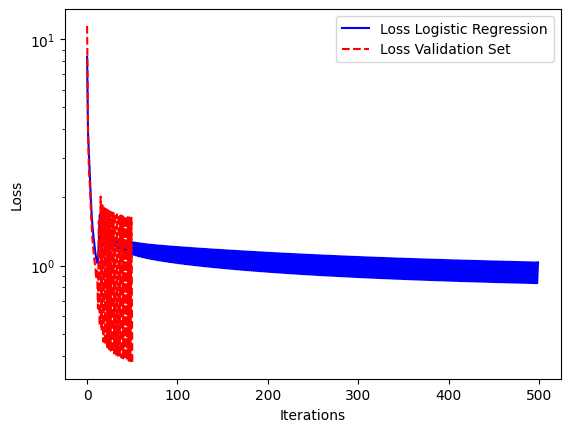

In [254]:
loss_validation_set = []
k = 0
for w in w_logreg:
    if k > 50:
        break
    k+= 1
    loss_validation_set.append(f.compute_loss_logistic(y_train_validation_lg, tX_train_validation, w))
    print(f.compute_loss_logistic(y_train_validation_lg, tX_train_validation, w))

ax = plt.axes()

plt.semilogy(loss_logreg, '-b', label='Loss Logistic Regression')
plt.semilogy(loss_validation_set, '--r', label='Loss Validation Set')
plt.legend(frameon=True)
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')

In [ ]:
y_pred = tX_train_validation.dot(w_logreg[-1])
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = np.where(y_pred == 1, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_validation)/len(y_train_validation))

print("F1 score: ", f1)

In [ ]:
y_test_logreg = tX_test.dot(w_logreg[-1, :])
y_test_logreg = np.where(y_test_logreg > 0.5, 1, 0)

print('weights = \n', w_logreg[-1,:],'\n Loss = ', loss_logreg[-1],'\n*****************************************************************************',
        ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train== 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_logreg == 1)/len(y_test_logreg))

In [ ]:
y_sub = np.where(y_test_logreg == 1, 1, -1)
h.create_csv_submission(test_ids, y_sub, 'submission_logreg.csv')

6. Regularized logistic regression

In [ ]:
#Try different values of gamma for gradient descent with MSE as loss function
#gamma = np.arange(10*10**(-2), 20*10**(-2), 1*10**(-2))
gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1]
lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1]
g_opti = gamma[0]
l_opti = lambdas[0]
loss_opti = 1000
for l in lambdas:
    for g in gamma:
        w_logreg, loss_logreg = f.reg_logistic_regression(y_train_train_lg, tX_train_train_reduced,l,  initial_w, 1000, g)
        if np.mean(loss_logreg[-10:]) < loss_opti:
            loss_opti = np.mean(loss_logreg[-10:])
            g_opti = g
            l_opti = l
        #print("%e, %e: %f" % (g, l, loss_logreg[-1]))
    plt.semilogy(loss_logreg, label = "%.5f, %.5f" % (g, l) )

print("optimal gamma: %e " % g_opti)
print("optimal lambda: %e " % l_opti)
plt.legend()
plt.show()

In [ ]:
w_reg_logreg, loss_reg_logreg = f.reg_logistic_regression(y_train_train_lg, tX_train_train_reduced, l_opti, initial_w, 6000, g_opti)

In [ ]:
y_pred = tX_train_test.dot(w_reg_logreg[-1])
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = np.where(y_pred == 1, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))

print("F1 score: ", f1)

In [ ]:
y_test_reg_logreg = tX_test.dot(w_reg_logreg[-1])
y_test_reg_logreg = np.where(y_test_reg_logreg > 0.5, 1, 0)

print('weights = \n', w_reg_logreg[-1],'\n Loss = ', loss_reg_logreg[-1],'\n*****************************************************************************',
        ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_reg_logreg == 1)/len(y_test_reg_logreg))


In [ ]:
y_sub = np.where(y_test_reg_logreg == 1, 1, -1)
h.create_csv_submission(test_ids, y_sub, 'submission_reg_logreg7.csv')